In [1]:
import numpy as np
import pandas as pd
import struct
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
npxor = np.frompyfunc(np.bitwise_xor, 2, 1)

In [3]:
def lzc(t):
    return 32 - len(np.binary_repr(t))
lzcv = np.frompyfunc(lzc, 1, 1)

In [4]:
def to_u32(f):
    s = struct.pack('>f',f)
    return struct.unpack('>l', s)[0]
to_u32v = np.frompyfunc(to_u32, 1, 1)

In [5]:
def mean_lzc(m, o):
    dist = np.random.normal(m,o,size=1000)
    truth = to_u32(m)
    vals = to_u32v(dist)
    xors = npxor(vals, truth)
    lzcs = lzcv(xors)
    return lzcs.mean()

def mean_lzc_group(m, o):
    dist = np.random.normal(m,o,size=1000)
    truth = to_u32(m)
    vals = to_u32v(dist)
    xors = npxor(vals, truth)
    lzcs = lzcv(xors)
    return lzcs
    return lzcs.mean()

## TODO

- [x] Plot LZC($\mu$)
- [x] Plot LZC($\sigma$)
- [ ] Find out with what $\sigma$ we are working for different predictors for climate data
    - [ ] Mean/Std of residuals?
    - [ ] Mean/Std of LZC of residuals?
    - [ ] Mean/Std of Error of predictor?
- [ ] Plot compression ratio dependency of $\mu$
- [ ] Plot compression ratio dependency of $\sigma$
- [x] Mark the 0101010101 shift values in the plot
- [x] Mark the 1010101010 shift values in the plot
- [x] Change the binary representation of numbers to grey plot LZC

# Calculate shift goals

In [6]:
def get_flipping_value(val):
    assert val & (val-1) == 0, "Not power of two"
    i = len(np.binary_repr(val)) - 3
    while i >= 0:
        val += 1 << i
        i -= 2
    return val

def get_mirrored_flipping_value(val):
#     return int(get_flipping_value(val) - 2*(get_flipping_value(val) - val*1.25))
    flipped = get_flipping_value(val)
    b = val + (val >> 2)
    a = (flipped - b) << 1
    return flipped - a - 1 

def get_close_flipping_value(val):
    # 2**x + ((mflip - 2**x) >> 2)
    return val + ((get_mirrored_flipping_value(val) - val) >> 2)

In [7]:
def get_closest_pow_2(val):
    next_smaller = next_smaller_pow_two(val)
    diff_smaller = val - next_smaller
    next_bigger = next_bigger_pow_two(val)
    diff_bigger = next_bigger - val
    if diff_bigger < diff_smaller:
        return next_bigger
    else:
        return next_smaller

def next_bigger_pow_two(val):
    return 1 << len(np.binary_repr(val))

def next_smaller_pow_two(val):
    return 1 << len(np.binary_repr(val)) - 1

In [8]:
def get_shifted_goal(val, method='closest', mode='flip'):
    # Calculate power of two on which the shift should be based
    if val != 0 and val & (val-1) == 0:
        val = val
    elif method in ('closest', 'c'):
        val = get_closest_pow_2(val)
    elif method in ('smaller', 's'):
        val = next_smaller_pow_two(val)
    elif method in ('bigger', 'b'):
        val = next_bigger_pow_two(val)
    else:
        raise Exception("Could not understand method '{}'".format(method))
    
    if mode == 'flip':
        return get_flipping_value(val)
    elif mode == 'mflip':
        return get_mirrored_flipping_value(val)
    elif mode == 'cflip':
        return get_close_flipping_value(val)
    else:
        raise Exception("Could not understand mode '{}'".format(mode))    

# LZC($\mu$)

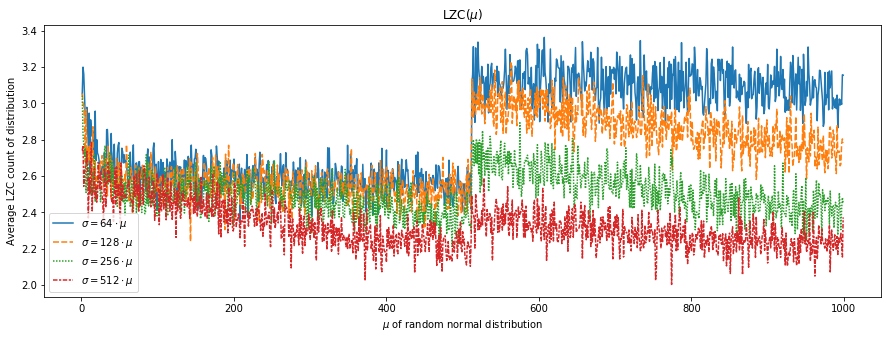

In [9]:
mu = np.arange(1000)
sigma1 =  64 * mu
sigma2 = 128 * mu
sigma3 = 256 * mu
sigma4 = 512 * mu

result1_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma1)]
result2_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma2)]
result3_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma3)]
result4_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma4)]

factors = [1.75,1.625,1.5,1.25,1.125,1]
fcolors = ['crimson','magenta','skyblue','limegreen','olivedrab', 'goldenrod']

# LZC(mu)
_, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pd.DataFrame({'$\sigma = 64 \cdot \mu$':result1_x_is_mu, '$\sigma = 128 \cdot \mu$':result2_x_is_mu, 
                                '$\sigma = 256 \cdot \mu$':result3_x_is_mu, '$\sigma = 512 \cdot \mu$':result4_x_is_mu})[1:])
plt.legend()
plt.title("LZC($\mu$)")
ax.set_xlabel("$\mu$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
# plt.savefig('lzc_mu_set2.svg')
plt.show()

/home/ucyo/Environments/infospace/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


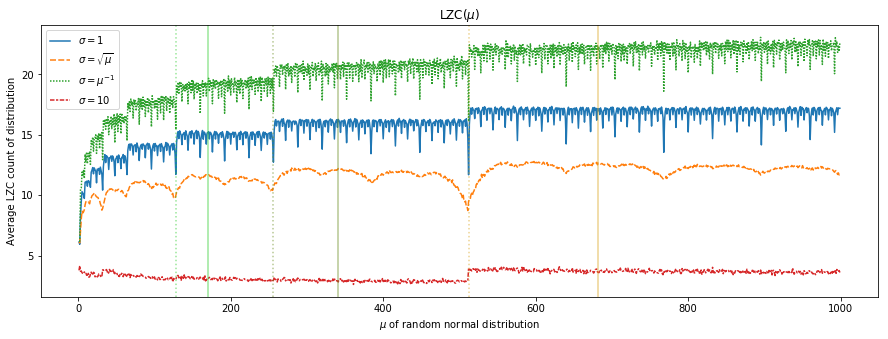

In [50]:
mu = np.arange(1000)
sigma1 = [1] * mu.size
sigma2 = np.sqrt(mu)
sigma3 = 1./mu
sigma4 = [10] * mu

result1_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma1)]
result2_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma2)]
result3_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma3)]
result4_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma4)]

factors = [1.75,1.625,1.5,1.25,1.125,1]
fcolors = ['crimson','magenta','skyblue','limegreen','olivedrab', 'goldenrod']

# LZC(mu)
_, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pd.DataFrame({'$\sigma = 1$':result1_x_is_mu, '$\sigma = \sqrt{\mu}$':result2_x_is_mu, 
                                '$\sigma = \mu^{-1}$':result3_x_is_mu, '$\sigma = 10$':result4_x_is_mu})[1:])
# for x in range(4,10):
#     flip = get_shifted_goal(2**x, method='c', mode='flip')
#     mflip = get_shifted_goal(2**x, method='c', mode='mflip')
#     cflip = get_shifted_goal(2**x, method='c', mode='cflip')
#     _ = plt.axvline(2**x, alpha=.5, color=fcolors[x-4], ls=":")
#     _ = plt.axvline(flip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(mflip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(cflip, alpha=.5, color=fcolors[x-4], ls="-")
for x in range(7,10):
    flip = get_shifted_goal(2**x, method='c', mode='flip')
    mflip = get_shifted_goal(2**x, method='c', mode='mflip')
    cflip = get_shifted_goal(2**x, method='c', mode='cflip')
    _ = plt.axvline(2**x, alpha=.5, color=fcolors[x-4], ls=":")
    _ = plt.axvline(flip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(mflip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(cflip, alpha=.5, color=fcolors[x-4], ls="-")
plt.legend()
plt.title("LZC($\mu$)")
ax.set_xlabel("$\mu$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
# plt.savefig('lzc_mu_set2.svg')
plt.savefig('/home/ucyo/Developments/encoding-paper/pics/gaussian-straight.pdf')
plt.show()

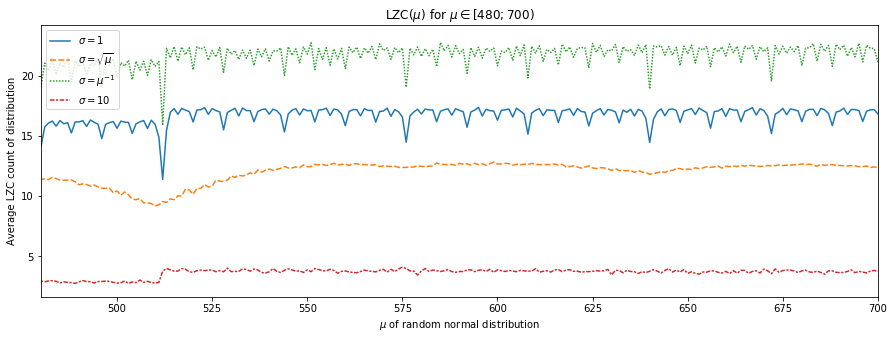

In [11]:
# LZC(mu)
_, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pd.DataFrame({'$\sigma = 1$':result1_x_is_mu, '$\sigma = \sqrt{\mu}$':result2_x_is_mu, 
                                '$\sigma = \mu^{-1}$':result3_x_is_mu, '$\sigma = 10$':result4_x_is_mu})[1:])
# for x in range(4,10):
#     flip = get_shifted_goal(2**x, method='c', mode='flip')
#     mflip = get_shifted_goal(2**x, method='c', mode='mflip')
#     cflip = get_shifted_goal(2**x, method='c', mode='cflip')
#     _ = plt.axvline(2**x, alpha=.5, color=fcolors[x-4], ls=":")
#     _ = plt.axvline(flip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(mflip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(cflip, alpha=.5, color=fcolors[x-4], ls="-")
plt.xlim((480, 700))
plt.legend()
plt.title("LZC($\mu$) for $\mu \in [480;700)$")
ax.set_xlabel("$\mu$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
# plt.savefig('lzc_mu_set2_zoom.svg')
plt.show()

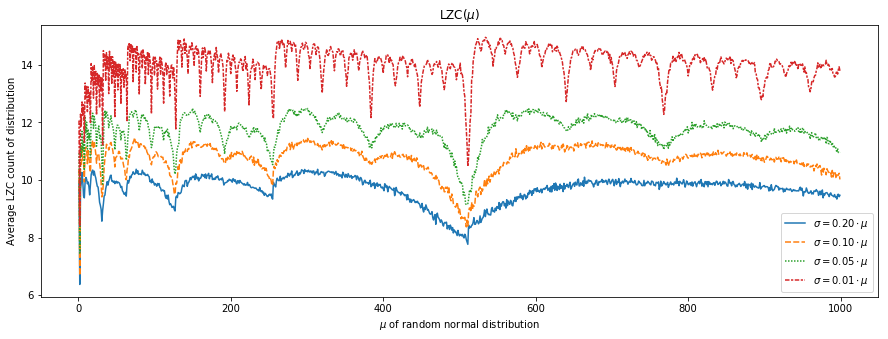

In [12]:
mu = np.arange(1000)
sigma1 = mu*.20
sigma2 = mu*.10
sigma3 = mu*.05
sigma4 = mu*.01

result1_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma1)]
result2_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma2)]
result3_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma3)]
result4_x_is_mu = [mean_lzc(m,o) for m,o in zip(mu,sigma4)]

factors = [1.75,1.625,1.5,1.25,1.125,1]
fcolors = ['crimson','magenta','skyblue','limegreen','olivedrab', 'goldenrod']

# LZC(mu)
_, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pd.DataFrame({'$\sigma = 0.20 \cdot \mu$':result1_x_is_mu, '$\sigma = 0.10 \cdot \mu$':result2_x_is_mu, 
                                '$\sigma = 0.05 \cdot \mu$':result3_x_is_mu, '$\sigma = 0.01 \cdot \mu$':result4_x_is_mu})[1:])
# for i,f in enumerate(factors):
#     [plt.axvline(2**x*f, alpha=.5, color=fcolors[i], ls=":") for x in range(4,10)];
plt.legend()
plt.title("LZC($\mu$)")
ax.set_xlabel("$\mu$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
# plt.savefig('lzc_mu_set2.svg')
plt.show()

In [13]:
# Vertical lines at above plot
base = 128
for i,f in enumerate(factors):
    print("{:.4f} {:>9} {:>10}".format(f, np.binary_repr(int(base*f), 8), fcolors[i]))

1.7500  11100000    crimson
1.6250  11010000    magenta
1.5000  11000000    skyblue
1.2500  10100000  limegreen
1.1250  10010000  olivedrab
1.0000  10000000  goldenrod


# LZC($\mu$) with shift goals

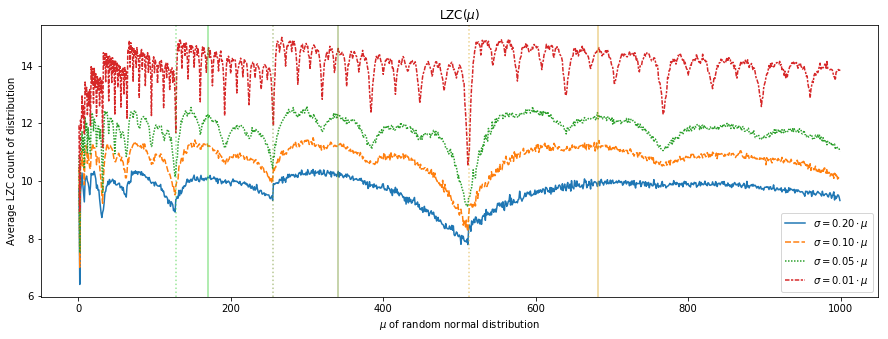

In [48]:
# LZC(mu)
_, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pd.DataFrame({'$\sigma = 0.20 \cdot \mu$':result1_x_is_mu, '$\sigma = 0.10 \cdot \mu$':result2_x_is_mu, 
                                '$\sigma = 0.05 \cdot \mu$':result3_x_is_mu, '$\sigma = 0.01 \cdot \mu$':result4_x_is_mu})[1:])
for x in range(7,10):
    flip = get_shifted_goal(2**x, method='c', mode='flip')
    mflip = get_shifted_goal(2**x, method='c', mode='mflip')
    cflip = get_shifted_goal(2**x, method='c', mode='cflip')
    _ = plt.axvline(2**x, alpha=.5, color=fcolors[x-4], ls=":")
    _ = plt.axvline(flip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(mflip, alpha=.5, color=fcolors[x-4], ls="-")
#     _ = plt.axvline(cflip, alpha=.5, color=fcolors[x-4], ls="-")
plt.legend()
plt.title("LZC($\mu$)")
ax.set_xlabel("$\mu$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
plt.savefig('/home/ucyo/Developments/encoding-paper/pics/gaussian.pdf')
plt.show()

In [15]:
x = 512
(f,mf,cf) = (get_shifted_goal(x, method='c', mode='flip'), 
             get_shifted_goal(x, method='c', mode='mflip'),
             get_shifted_goal(x, method='c', mode='cflip')
            )

In [16]:
[(r, np.binary_repr(r)) for r in [x,cf,mf,f]]

[(512, '1000000000'),
 (533, '1000010101'),
 (597, '1001010101'),
 (682, '1010101010')]

# LZC($\mu$) using greycodes

In [17]:
def _to_grey(num):
    return num ^ (num >> 1)
to_grey = np.frompyfunc(_to_grey, 1, 1)

def _from_grey(num):
    number = num;
    mask = number >> 1;
    while mask != 0:
        number = number ^ mask;
        mask = mask >> 1;
    return number

def mean_grey_lzc(m, o, fn=to_grey):
    dist = np.random.normal(m,o,size=1000)
    truth = to_u32(m)
    vals = to_u32v(dist)
    vals = fn(vals)
    xors = npxor(vals, fn(truth))
    lzcs = lzcv(xors).astype('uint8')
    return lzcs.mean()

def lzc_grey_arr(m, o, fn=to_grey):
    dist = np.random.normal(m,o,size=1000)
    truth = to_u32(m)
    vals = to_u32v(dist)
    vals = fn(vals)
    xors = npxor(vals, fn(truth))
    lzcs = lzcv(xors).astype('uint8')
    return lzcs

def lzc_arr(m, o):
    dist = np.random.normal(m,o,size=1000)
    truth = to_u32(m)
    vals = to_u32v(dist)
    xors = npxor(vals, truth)
    lzcs = lzcv(xors).astype('uint8')
    return lzcs

In [18]:
mu = np.arange(1000)
sigma1 = mu*.20
sigma2 = mu*.10
sigma3 = mu*.05
sigma4 = mu*.01

result1_x_is_mu = [mean_grey_lzc(m,o) for m,o in zip(mu,sigma1)]
result2_x_is_mu = [mean_grey_lzc(m,o) for m,o in zip(mu,sigma2)]
result3_x_is_mu = [mean_grey_lzc(m,o) for m,o in zip(mu,sigma3)]
result4_x_is_mu = [mean_grey_lzc(m,o) for m,o in zip(mu,sigma4)]

factors = [1.75,1.625,1.5,1.25,1.125,1]
fcolors = ['crimson','magenta','skyblue','limegreen','olivedrab', 'goldenrod']

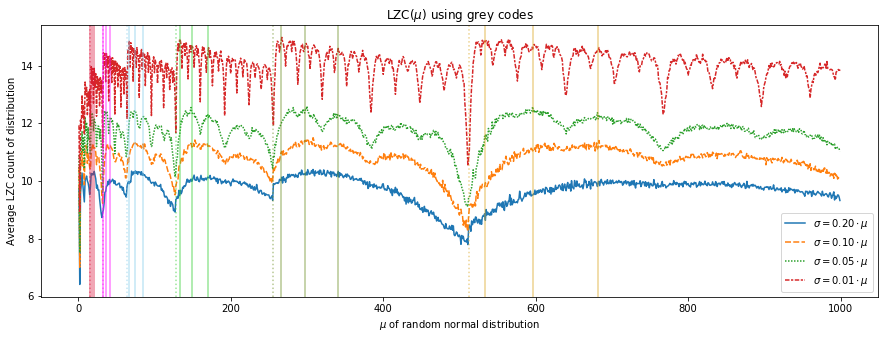

In [19]:
# LZC(mu)
_, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=pd.DataFrame({'$\sigma = 0.20 \cdot \mu$':result1_x_is_mu, '$\sigma = 0.10 \cdot \mu$':result2_x_is_mu, 
                                '$\sigma = 0.05 \cdot \mu$':result3_x_is_mu, '$\sigma = 0.01 \cdot \mu$':result4_x_is_mu})[1:])
for x in range(4,10):
    flip = get_shifted_goal(2**x, method='c', mode='flip')
    mflip = get_shifted_goal(2**x, method='c', mode='mflip')
    cflip = get_shifted_goal(2**x, method='c', mode='cflip')
    _ = plt.axvline(2**x, alpha=.5, color=fcolors[x-4], ls=":")
    _ = plt.axvline(flip, alpha=.5, color=fcolors[x-4], ls="-")
    _ = plt.axvline(mflip, alpha=.5, color=fcolors[x-4], ls="-")
    _ = plt.axvline(cflip, alpha=.5, color=fcolors[x-4], ls="-")
plt.legend()
plt.title("LZC($\mu$) using grey codes")
ax.set_xlabel("$\mu$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
# plt.savefig('lzc_mu_set2.svg')
plt.show()

In [20]:
for v in [2**x, cflip, mflip, flip]:
    print(v, np.binary_repr(v), to_grey(v), np.binary_repr(to_grey(v)))

512 1000000000 768 1100000000
533 1000010101 799 1100011111
597 1001010101 895 1101111111
682 1010101010 1023 1111111111


In [21]:
np.binary_repr(3 << 30, 32)

'11000000000000000000000000000000'

In [22]:
np.binary_repr((4294967295 >> 5) + (3 << 30), 32)

'11000111111111111111111111111111'

In [23]:
int("1100"*2, 2)

204

## LZC($\mu$) Analysis of potential manipulations of greycodes

In [24]:
def to_grey_with_shift(val):
    temp = to_grey(val)
    return temp + 512

m, s = 512, 10
fn = to_grey_with_shift
dict(mglzc=mean_grey_lzc(get_close_flipping_value(m), s, fn).mean(), 
     mlzc=mean_lzc_group(get_close_flipping_value(m), s).mean()
)

{'mglzc': 13.934, 'mlzc': 13.897}

In [25]:
val = 512
for k in [val-1, val, val+1]:
    print(k, np.binary_repr(k), np.binary_repr(to_grey(k)))
print('')
for i in range(-10,10):
    k = val - i
    kn = k
    print("{:03} {:0>10} {:0>10}".format(k, np.binary_repr(kn), np.binary_repr(to_grey(kn))))

511 111111111 100000000
512 1000000000 1100000000
513 1000000001 1100000001

522 1000001010 1100001111
521 1000001001 1100001101
520 1000001000 1100001100
519 1000000111 1100000100
518 1000000110 1100000101
517 1000000101 1100000111
516 1000000100 1100000110
515 1000000011 1100000010
514 1000000010 1100000011
513 1000000001 1100000001
512 1000000000 1100000000
511 0111111111 0100000000
510 0111111110 0100000001
509 0111111101 0100000011
508 0111111100 0100000010
507 0111111011 0100000110
506 0111111010 0100000111
505 0111111001 0100000101
504 0111111000 0100000100
503 0111110111 0100001100


# LZC($\sigma$)

In [26]:
sigma = np.arange(1000)
mu1 = 10 * sigma
mu2 = 50 * sigma
mu3 = 100 * sigma
mu4 = 500 * sigma

result1_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu1,sigma)]
result2_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu2,sigma)]
result3_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu3,sigma)]
result4_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu4,sigma)]

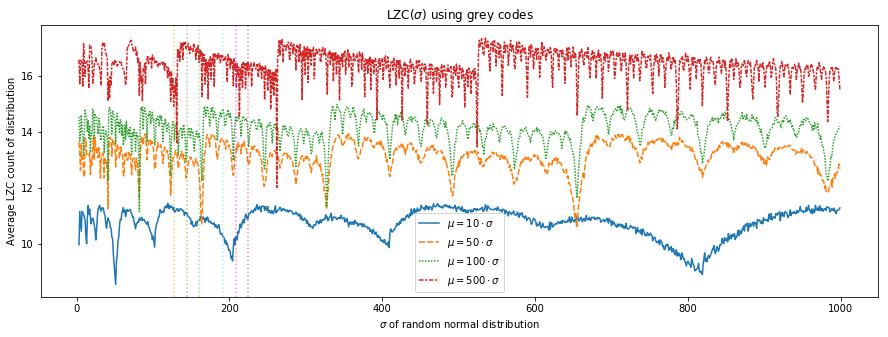

In [27]:
# LZC(sigma)
_, ax = plt.subplots(figsize=(15,5))
df = pd.DataFrame({'$\mu =  10 \cdot \sigma$':result1_x_is_sigma, 
                   '$\mu =  50 \cdot \sigma$':result2_x_is_sigma, 
                   '$\mu = 100 \cdot \sigma$':result3_x_is_sigma, 
                   '$\mu = 500 \cdot \sigma$':result4_x_is_sigma,
})
sns.lineplot(data=df[3:])
for i,f in enumerate(factors):
    [plt.axvline(128*f, alpha=.5, color=fcolors[i], ls=":")];
plt.legend()
plt.title("LZC($\sigma$) using grey codes")
ax.set_xlabel("$\sigma$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
# plt.savefig('lzc_mu_set2.svg')
plt.show()

In [28]:
sigma = np.arange(1000)
mu1 = [128 * 2] * sigma.size
mu2 = [128 * 1.5] * sigma.size
mu3 = [128 * 1.125] * sigma.size
mu4 = [128] * sigma.size

result1_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu1,sigma)]
result2_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu2,sigma)]
result3_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu3,sigma)]
result4_x_is_sigma = [mean_lzc(m,o) for m,o in zip(mu4,sigma)]

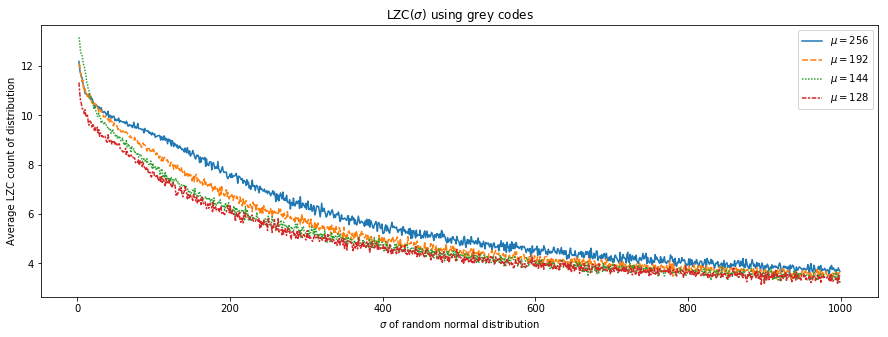

In [29]:
# LZC(sigma)
_, ax = plt.subplots(figsize=(15,5))
df = pd.DataFrame({"$\mu = {}$".format(int(mu1[0])):result1_x_is_sigma, 
                   "$\mu = {}$".format(int(mu2[0])):result2_x_is_sigma, 
                   "$\mu = {}$".format(int(mu3[0])):result3_x_is_sigma, 
                   "$\mu = {}$".format(int(mu4[0])):result4_x_is_sigma,
})
sns.lineplot(data=df[2:])
plt.legend()
plt.title("LZC($\sigma$) using grey codes")
ax.set_xlabel("$\sigma$ of random normal distribution")
ax.set_ylabel("Average LZC count of distribution")
# plt.savefig('lzc_mu_set2.svg')
plt.show()

In [30]:
# Vertical lines at above plot
base = 128
for i,f in enumerate(factors):
    print("{:.4f} {:>9} {:>10}".format(f, np.binary_repr(int(base*f), 8), fcolors[i]))

1.7500  11100000    crimson
1.6250  11010000    magenta
1.5000  11000000    skyblue
1.2500  10100000  limegreen
1.1250  10010000  olivedrab
1.0000  10000000  goldenrod


# $\sigma$ for different climate data

This part of the analysis must be specified more in detail. Espacially being specific about what should be analyzed. Options are:

- Mean/Std of residuals?
- Mean/Std of LZC of residuals?
- Mean/Std of Error of predictor?

In [31]:
from glob import glob

In [32]:
def describe_data(regex):
#     
    residual_files = glob(regex)
    df = pd.DataFrame(index=['mean', 'std'])

    for k in residual_files:
        data = np.fromfile(k, dtype='uint32')
        ps = lzcv(data)
        mean = ps.mean()
        std = ps.std()
        df[k[2:]] = [mean, std]

    df = df.T
    df['pcent'] = (df['std'] / df['mean']) * 100
    return df

def describe_lzc_data(regex):
    residual_files = sorted(glob(regex))
    df = pd.DataFrame(index=['mean', 'std'])

    for k in residual_files:
        data = np.fromfile(k, dtype='uint32')
        ps = ps.Series(data)
        mean = ps.mean()
        std = ps.std()
        df[k[2:]] = [mean, std]

    df = df.T
    df['pcent'] = (df['std'] / df['mean']) * 100
    return df

In [33]:
# describe_data("./*.residual")

In [34]:
# describe_data('../../pzip/data/*.raw')

In [35]:
# describe_data("./*.bplanes")

In [36]:
# describe_data("./*.nlzc")

In [37]:
# df = describe_data('./*.residual')

In [38]:
# df['mean'].plot()